# Training an agent to play Mario

In [3]:
import torch
from torch import nn
from torchvision import transforms as T
from PIL import Image
import numpy as np
from pathlib import Path
from collections import deque
import random, datetime, os, sys

# A tool kit for RL
import gymnasium as gym
import matplotlib.pyplot as plt

from tensordict import TensorDict
from torchrl.data import TensorDictReplayBuffer, LazyMemmapStorage

# NES Emulator
from nes_py.wrappers import JoypadSpace

# A tool kit for visualization
from JSAnimation.IPython_display import display_animation
from matplotlib import animation

# Add the src directory to the Python path
src_path = Path.cwd().parent / "src"
if src_path not in sys.path:
    sys.path.append(str(src_path))

%matplotlib inline

## Environment

Below shows how we can create an environment with customized action sets.

In [2]:
import gymnasium as gym
from env import create_env, __version__

print(f'Using environment version: {__version__}')

# Create environment with full action space
env = create_env("ALE/MarioBros-v5", full_action_space=True)
state = env.reset()

# Print the observation space and action space
print(f'state: {state}')
print(f'Observation space: {env.observation_space}')
print(f'Action space: {env.action_space}')

env.close()

Using environment version: 0.1.0
state: (<gymnasium.wrappers.frame_stack.LazyFrames object at 0x7f849d9e3b00>, {'lives': 5, 'episode_frame_number': 0, 'frame_number': 0})
Observation space: Box(0, 255, (4, 84, 84), uint8)
Action space: Discrete(18)


A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
/home/tianyhe/miniconda3/envs/mario-rl/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [3]:
import gymnasium as gym
from env import SIMPLE_MOVEMENT, create_env, __version__

print(f'Using environment version: {__version__}')

# Create environment with simple movement action space
env = create_env("ALE/MarioBros-v5", 
                 action_set=SIMPLE_MOVEMENT, 
                 skip_frames=2, 
                 gray_scale=False, 
                 resize_shape=64,
                 full_action_space=False)
state = env.reset()

# Print the observation space and action space
print(f'Observation space: {env.observation_space}')
print(f'Action space: {env.action_space}')

env.close()

Using environment version: 0.1.0
Observation space: Box(0, 255, (4, 64, 64, 3), uint8)
Action space: Discrete(7)


In [4]:
import gymnasium as gym
from env import COMPLEX_MOVEMENT, create_env, __version__

print(f'Using environment version: {__version__}')

# Create environment with complex movement action space
env = create_env("ALE/MarioBros-v5", 
                 action_set=COMPLEX_MOVEMENT, 
                 full_action_space=False)
state = env.reset()

# Print the observation space and action space
print(f'Observation space: {env.observation_space}')
print(f'Action space: {env.action_space}')

env.close()

Using environment version: 0.1.0
Observation space: Box(0, 255, (4, 84, 84), uint8)
Action space: Discrete(12)


In [5]:
import gymnasium as gym
from env import create_env, __version__

print(f'Using environment version: {__version__}')

# Create environment with default RIGHT_ONLY action space
env = create_env("ALE/MarioBros-v5", full_action_space=False)
state = env.reset()

# Print the observation space and action space
print(f'Observation space: {env.observation_space}')
print(f'Action space: {env.action_space}')

Using environment version: 0.1.0
Observation space: Box(0, 255, (4, 84, 84), uint8)
Action space: Discrete(5)


Visualize how the agent play the game by randomly selecting actions.

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
/home/tianyhe/miniconda3/envs/mario-rl/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/tianyhe/miniconda3/envs/mario-rl/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are 

Initial observation shape: torch.Size([84, 84])
Observation type: <class 'torch.Tensor'>
Frame shape at step 0: (84, 84)
Frame shape at step 1: (84, 84)
Frame shape at step 2: (84, 84)
Frame shape at step 3: (84, 84)
Frame shape at step 4: (84, 84)
Frame shape at step 5: (84, 84)
Frame shape at step 6: (84, 84)
Frame shape at step 7: (84, 84)
Frame shape at step 8: (84, 84)
Frame shape at step 9: (84, 84)
Frame shape at step 10: (84, 84)
Frame shape at step 11: (84, 84)
Frame shape at step 12: (84, 84)
Frame shape at step 13: (84, 84)
Frame shape at step 14: (84, 84)
Frame shape at step 15: (84, 84)
Frame shape at step 16: (84, 84)
Frame shape at step 17: (84, 84)
Frame shape at step 18: (84, 84)
Frame shape at step 19: (84, 84)
Frame shape at step 20: (84, 84)
Frame shape at step 21: (84, 84)
Frame shape at step 22: (84, 84)
Frame shape at step 23: (84, 84)
Frame shape at step 24: (84, 84)
Frame shape at step 25: (84, 84)
Frame shape at step 26: (84, 84)
Frame shape at step 27: (84, 8

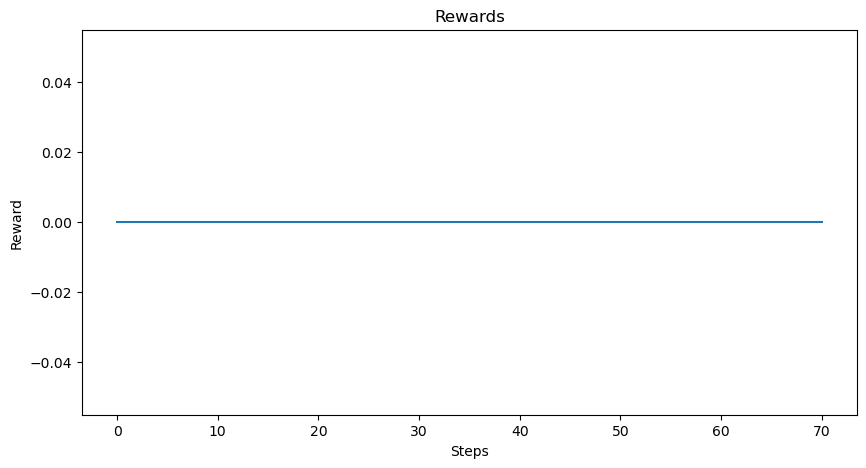

Sum of rewards is  0.0


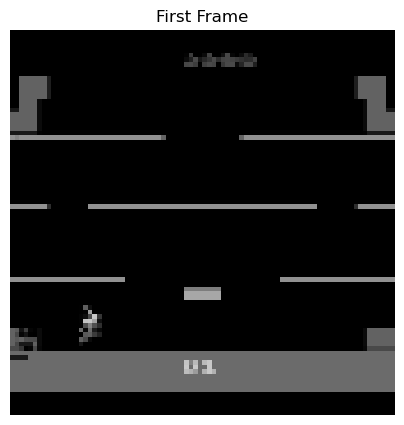

In [4]:
from utils import display_frames_as_gif
import numpy as np
import matplotlib.pyplot as plt
from env import create_env

env = create_env("ALE/MarioBros-v5", stack_frames=1, full_action_space=False, gray_scale=True, resize_shape=84)

# Environment reset and frame capture
observation, info = env.reset()
r = []
infos = []
MAX_STEPS = 500
frames = []

print(f"Initial observation shape: {observation.shape}")
print(f"Observation type: {type(observation)}")

for step in range(MAX_STEPS):
    # Capture the processed observation
    if isinstance(observation, np.ndarray):
        frame = observation
    elif hasattr(observation, '__array__'):  # LazyFrames from FrameStack
        frame = np.array(observation)
    else:
        frame = np.array(observation)
    
    print(f"Frame shape at step {step}: {frame.shape}")

    # Use the most recent frame if it is a stacked frame
    if len(frame.shape) == 3 and frame.shape[0] == 4:  # Stacked frames
        frame = frame[-1]  # Get the most recent frame
    
    # If the frame is 2D (grayscale), repeat it to create a 3D array for visualization
    if len(frame.shape) == 2:
        frame = np.repeat(frame[:, :, np.newaxis], 3, axis=2)
    
    frames.append(frame)
    
    action = env.action_space.sample()  # replace with your agent's action
    observation, reward, done, trunc, info = env.step(action)
    
    infos.append(info)
    r.append(reward)
    
    if done or trunc:
        break

r = np.array(r)

print(f"\nTotal frames captured: {len(frames)}")
print(f"Shape of first frame in frames list: {frames[0].shape}")

# Display frames as GIF
display_frames_as_gif(frames)

# Plot rewards
plt.figure(figsize=(10, 5))
plt.plot(r)
plt.title('Rewards')
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.show()

print('Sum of rewards is ', r.sum())

# Display a single frame for inspection
plt.figure(figsize=(5, 5))
plt.imshow(frames[0], cmap='gray')
plt.title('First Frame')
plt.axis('off')
plt.show()

Visualize how the agent plays the game by randomly selecting actions. (stacked 4 frames)

/home/tianyhe/miniconda3/envs/mario-rl/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Initial observation shape: (4, 84, 84)
Observation type: <class 'gymnasium.wrappers.frame_stack.LazyFrames'>
Frame shape at step 0: (4, 84, 84)
Frame shape at step 1: (4, 84, 84)
Frame shape at step 2: (4, 84, 84)
Frame shape at step 3: (4, 84, 84)
Frame shape at step 4: (4, 84, 84)
Frame shape at step 5: (4, 84, 84)
Frame shape at step 6: (4, 84, 84)
Frame shape at step 7: (4, 84, 84)
Frame shape at step 8: (4, 84, 84)
Frame shape at step 9: (4, 84, 84)
Frame shape at step 10: (4, 84, 84)
Frame shape at step 11: (4, 84, 84)
Frame shape at step 12: (4, 84, 84)
Frame shape at step 13: (4, 84, 84)
Frame shape at step 14: (4, 84, 84)
Frame shape at step 15: (4, 84, 84)
Frame shape at step 16: (4, 84, 84)
Frame shape at step 17: (4, 84, 84)
Frame shape at step 18: (4, 84, 84)
Frame shape at step 19: (4, 84, 84)
Frame shape at step 20: (4, 84, 84)
Frame shape at step 21: (4, 84, 84)
Frame shape at step 22: (4, 84, 84)
Frame shape at step 23: (4, 84, 84)
Frame shape at step 24: (4, 84, 84)
F

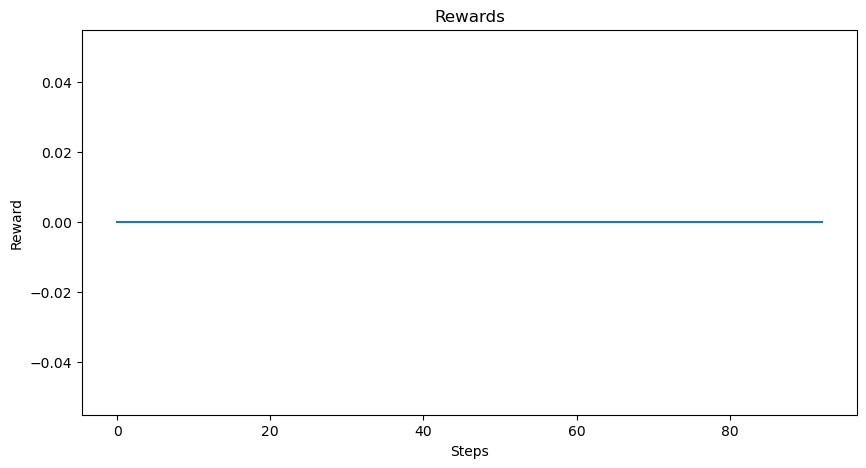

Sum of rewards is  0.0


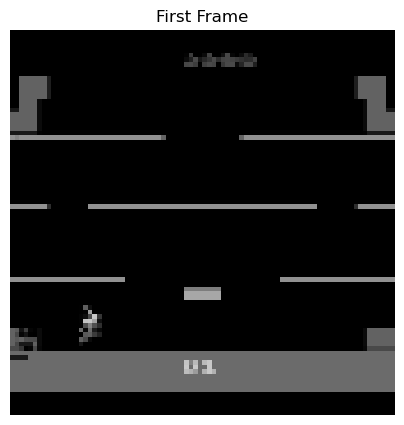

In [5]:
from utils import display_frames_as_gif
import numpy as np
import matplotlib.pyplot as plt
from env import create_env

env = create_env("ALE/MarioBros-v5", stack_frames=4, full_action_space=False, gray_scale=True, resize_shape=84)

# Environment reset and frame capture
observation, info = env.reset()
r = []
infos = []
MAX_STEPS = 500
frames = []

print(f"Initial observation shape: {observation.shape}")
print(f"Observation type: {type(observation)}")

for step in range(MAX_STEPS):
    # Capture the processed observation
    if isinstance(observation, np.ndarray):
        frame = observation
    elif hasattr(observation, '__array__'):  # LazyFrames from FrameStack
        frame = np.array(observation)
    else:
        frame = np.array(observation)
    
    print(f"Frame shape at step {step}: {frame.shape}")

    # Use the most recent frame if it is a stacked frame
    if len(frame.shape) == 3 and frame.shape[0] == 4:  # Stacked frames
        frame = frame[-1]  # Get the most recent frame
    
    # If the frame is 2D (grayscale), repeat it to create a 3D array for visualization
    if len(frame.shape) == 2:
        frame = np.repeat(frame[:, :, np.newaxis], 3, axis=2)
    
    frames.append(frame)
    
    action = env.action_space.sample()  # replace with your agent's action
    observation, reward, done, trunc, info = env.step(action)
    
    infos.append(info)
    r.append(reward)
    
    if done or trunc:
        break

r = np.array(r)

print(f"\nTotal frames captured: {len(frames)}")
print(f"Shape of first frame in frames list: {frames[0].shape}")

# Display frames as GIF
display_frames_as_gif(frames)

# Plot rewards
plt.figure(figsize=(10, 5))
plt.plot(r)
plt.title('Rewards')
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.show()

print('Sum of rewards is ', r.sum())

# Display a single frame for inspection
plt.figure(figsize=(5, 5))
plt.imshow(frames[0], cmap='gray')
plt.title('First Frame')
plt.axis('off')
plt.show()

After applying wrappers to the environment, the state space is reduced to 84x84x4. The agent will use a Dueling Double Deep Q-Network (Dueling DDQN) with Prioritized Experience Replay to learn the Q-values.

## Training

### Environment Setup

We use a custom environment setup for Super Mario Bros, which includes:

- Custom action space (SIMPLE_MOVEMENT)
- Frame skipping (4 frames)
- Grayscale conversion
- Observation resizing (84x84)
- Frame stacking (4 frames)

This preprocessing helps to reduce the input complexity and speed up training.

### Training Setup

The training process is configured with the following hyperparameters:

- **State and Action Dimensions:**
  - `state_dim`: The dimensionality of the state space.
  - `action_dim`: The number of possible actions.

- **Network Configuration:**
  - `network_type`: Specifies the type of Q-network to use, defaulting to "duelling" (which refers to the dueling architecture).
  - `ddqn`: Boolean flag indicating whether to use Double DQN (default: `True`).

- **Exploration Strategy:**
  - `exploration_rate`: Initial exploration rate set to 1.0, encouraging exploration at the start.
  - `exploration_rate_decay`: Decay factor for reducing exploration rate over time.
  - `exploration_rate_min`: Minimum value for exploration rate, preventing it from dropping too low (set to 0.1).

- **Training Parameters:**
  - `gamma`: Discount factor for future rewards (set to 0.9).
  - `optimizer`: Adam optimizer used with a learning rate of 0.00025.
  - `loss_fn`: Huber loss (SmoothL1Loss) is used to calculate the error between predicted and target Q-values.

- **Replay Buffer:**
  - `memory`: A replay buffer with a capacity of 1 million experiences, supporting prioritized replay if enabled.
  - `batch_size`: The size of each training batch (set to 32).

- **Training Schedule:**
  - `burnin`: Minimum number of experiences (10,000) required before starting the training process.
  - `learn_every`: The model updates the Q-network every 3 experiences.
  - `sync_every`: The target network is synchronized with the online network every 10,000 experiences.

- **Noise and Noise Decay:**
  - `noise`: Initial noise factor set to 0.05.
    - `noise_decay`: Noise decays by 0.99 every episode.

- **Model Saving:**
  - `save_every`: The model is saved every 500,000 experiences to ensure checkpoints are maintained during training.

### Implementation Details

In [1]:
"""
Training and evaluation functions for the Mario agent
"""
import sys
from pathlib import Path

src_path = Path.cwd().parent / "src"
if src_path not in sys.path:
    sys.path.append(str(src_path))


import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import datetime

from agent.mario import Mario
from utils import *
from env import create_env, SIMPLE_MOVEMENT


def train(
    env_id,
    episodes,
    save_dir,
    action_set=SIMPLE_MOVEMENT,
    network_type="duelling",
    ddqn=True,
    priority=True,
    discount_rate=0.99,
    skip_frames=4,
    stack_frames=4,
    resize_shape=84,
    tmax=500,
    initial_noise=0.05,
    noise_decay=0.99,
    use_cuda=True,
):
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)

    env = create_env(
        env_id,
        action_set=action_set,
        skip_frames=skip_frames,
        gray_scale=True,
        resize_shape=resize_shape,
        stack_frames=stack_frames,
    )

    state_dim = env.observation_space.shape
    action_dim = env.action_space.n

    logger = MetricLogger(save_dir)
    mario = Mario(
        state_dim,
        action_dim,
        save_dir,
        network_type=network_type,
        ddqn=ddqn,
        priority=priority,
        use_cuda=use_cuda,
    )

    for episode in range(episodes):
        state = env.reset()
        episode_reward = 0

        for step in range(tmax):
            action = mario.act(state, initial_noise * (noise_decay**episode))

            next_state, reward, done, truncated, info = env.step(action)

            mario.cache(state, next_state, action, reward, done)

            q, loss = mario.learn()
            logger.log_step(reward, loss, q)

            episode_reward += reward
            state = next_state

            if done or truncated:
                break

        logger.log_episode()

        if episode % 20 == 0:
            logger.record(
                episode, initial_noise * (noise_decay**episode), mario.curr_step
            )

    # Save the model
    network_type_str = "dueling" if network_type == "duelling" else "simple"
    dqn_type = "ddqn" if ddqn else "dqn"
    date_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    model_info = f"{network_type_str}_{dqn_type}_epo{episodes}_noise{initial_noise}_decay{noise_decay}"
    model_filename = f"../model/{model_info}_{date_time}.checkpt"
    mario.save(model_filename)
    print(f"Model saved as {model_filename}")
    
    return mario, logger


def evaluate(
    env_id,
    mario,
    episodes=1,
    tmax=500,
    action_set=SIMPLE_MOVEMENT,
    capture_frames=False,
):
    env = create_env(
        env_id,
        action_set=action_set,
    )
    all_frames = []
    total_rewards = []

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        episode_frames = []

        for t in range(tmax):
            action = mario.act(state)
            state, reward, done, truncated, info = env.step(action)

            total_reward += reward

            if capture_frames:
                episode_frames.append(env.render())

            if done or truncated:
                break

        print(f"Episode {episode + 1}: Total Reward: {total_reward}")
        total_rewards.append(total_reward)

        if capture_frames:
            all_frames.extend(episode_frames)

    env.close()
    average_reward = np.mean(total_rewards)
    print(f"Average Reward over {episodes} episodes: {average_reward}")

    return average_reward, all_frames if capture_frames else None


def plot_training_results(logger):
    plt.figure(figsize=(20, 5))
    plt.subplot(131)
    plt.title("Episode Rewards")
    plt.plot(logger.moving_avg_ep_rewards)
    plt.subplot(132)
    plt.title("Episode Lengths")
    plt.plot(logger.moving_avg_ep_lengths)
    plt.subplot(133)
    plt.title("Episode Avg Q-values")
    plt.plot(logger.moving_avg_ep_avg_qs)
    plt.show()


/home/tianyhe/miniconda3/envs/mario-rl/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### Duelling DDQN with Prioritized Experience Replay (Simple Action Space)

The agent uses two neural networks: the online network and the target network. The online network is updated every step, while the target network is updated every 1000 steps. 

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
/home/tianyhe/miniconda3/envs/mario-rl/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 0 - Step 383 - Epsilon 0.050 - Mean Reward 0.000 - Mean Length 383.000 - Mean Loss 0.000 - Mean Q Value 0.000 - Time Delta 1.493 - Time 2024-08-10T17:26:52
Episode 20 - Step 8092 - Epsilon 0.041 - Mean Reward 0.000 - Mean Length 385.333 - Mean Loss 0.000 - Mean Q Value 0.000 - Time Delta 15.675 - Time 2024-08-10T17:27:07


/home/tianyhe/miniconda3/envs/mario-rl/lib/python3.11/site-packages/torch/nn/modules/loss.py:942: UserWarning: Using a target size (torch.Size([32, 32])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


Episode 40 - Step 14879 - Epsilon 0.033 - Mean Reward 0.000 - Mean Length 362.902 - Mean Loss 0.001 - Mean Q Value 0.082 - Time Delta 36.269 - Time 2024-08-10T17:27:44
Episode 60 - Step 20878 - Epsilon 0.027 - Mean Reward 13.115 - Mean Length 342.262 - Mean Loss 0.122 - Mean Q Value 0.122 - Time Delta 39.356 - Time 2024-08-10T17:28:23
Episode 80 - Step 24844 - Epsilon 0.022 - Mean Reward 19.753 - Mean Length 306.716 - Mean Loss 0.461 - Mean Q Value 0.136 - Time Delta 26.473 - Time 2024-08-10T17:28:50
Episode 100 - Step 29517 - Epsilon 0.018 - Mean Reward 24.000 - Mean Length 291.340 - Mean Loss 1.093 - Mean Q Value 0.142 - Time Delta 30.977 - Time 2024-08-10T17:29:21
Episode 120 - Step 33877 - Epsilon 0.015 - Mean Reward 24.000 - Mean Length 257.850 - Mean Loss 1.730 - Mean Q Value 0.171 - Time Delta 30.802 - Time 2024-08-10T17:29:51
Episode 140 - Step 38282 - Epsilon 0.012 - Mean Reward 24.000 - Mean Length 234.030 - Mean Loss 2.738 - Mean Q Value 0.167 - Time Delta 30.298 - Time 2024

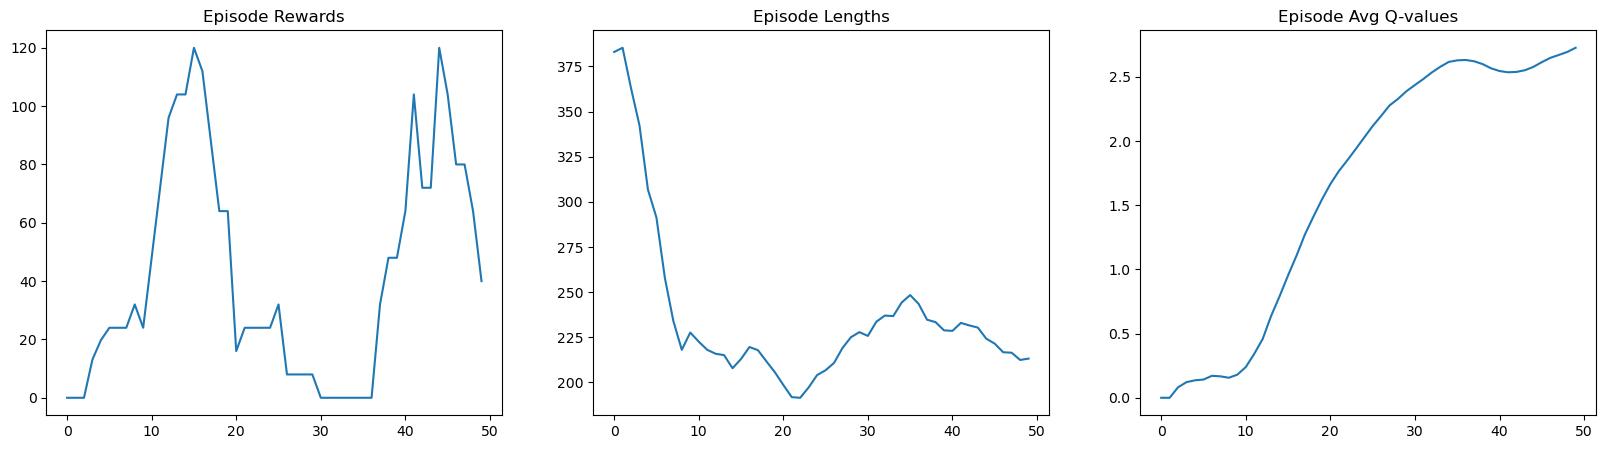

Average Reward over 0 episodes: nan
Evaluation reward: nan


/home/tianyhe/miniconda3/envs/mario-rl/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tianyhe/miniconda3/envs/mario-rl/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [2]:
# Define training parameters
ENV_ID = "ALE/MarioBros-v5"
EPISODES = 1000
SAVE_DIR = "./results/simple-1000-episodes-duelling-ddqn-priority"

# Train the agent
mario, logger = train(
    env_id=ENV_ID,
    episodes=EPISODES,
    save_dir=SAVE_DIR,
    action_set=SIMPLE_MOVEMENT,
    network_type="duelling",
    ddqn=True,
    priority=True,
    initial_noise=0.05,
    noise_decay=0.99
)

# Plot the training results
plot_training_results(logger)

# Evaluate the trained agent and capture gameplay frames
eval_reward, gameplay_frames = evaluate(ENV_ID, mario, episodes=0, action_set=SIMPLE_MOVEMENT, capture_frames=True)
print(f"Evaluation reward: {eval_reward}")

### Dueling DDQN with Prioritized Experience Replay (Complex Actions Space)

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
/home/tianyhe/miniconda3/envs/mario-rl/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 0 - Step 182 - Epsilon 0.050 - Mean Reward 0.000 - Mean Length 182.000 - Mean Loss 0.000 - Mean Q Value 0.000 - Time Delta 1.145 - Time 2024-08-10T20:52:24
Episode 20 - Step 3968 - Epsilon 0.041 - Mean Reward 38.095 - Mean Length 188.952 - Mean Loss 0.000 - Mean Q Value 0.000 - Time Delta 7.866 - Time 2024-08-10T20:52:32
Episode 40 - Step 7857 - Epsilon 0.033 - Mean Reward 58.537 - Mean Length 191.634 - Mean Loss 0.000 - Mean Q Value 0.000 - Time Delta 7.942 - Time 2024-08-10T20:52:40


/home/tianyhe/miniconda3/envs/mario-rl/lib/python3.11/site-packages/torch/nn/modules/loss.py:942: UserWarning: Using a target size (torch.Size([32, 32])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


Episode 60 - Step 11417 - Epsilon 0.027 - Mean Reward 39.344 - Mean Length 187.164 - Mean Loss 0.254 - Mean Q Value 0.034 - Time Delta 13.260 - Time 2024-08-10T20:52:53
Episode 80 - Step 15504 - Epsilon 0.022 - Mean Reward 29.630 - Mean Length 191.407 - Mean Loss 3.654 - Mean Q Value 0.099 - Time Delta 26.404 - Time 2024-08-10T20:53:19
Episode 100 - Step 19474 - Epsilon 0.018 - Mean Reward 24.000 - Mean Length 192.920 - Mean Loss 17.950 - Mean Q Value 0.155 - Time Delta 25.712 - Time 2024-08-10T20:53:45
Episode 120 - Step 24066 - Epsilon 0.015 - Mean Reward 48.000 - Mean Length 200.980 - Mean Loss 42.653 - Mean Q Value 0.257 - Time Delta 29.624 - Time 2024-08-10T20:54:15
Episode 140 - Step 28417 - Epsilon 0.012 - Mean Reward 32.000 - Mean Length 205.600 - Mean Loss 75.489 - Mean Q Value 0.377 - Time Delta 27.705 - Time 2024-08-10T20:54:42
Episode 160 - Step 33119 - Epsilon 0.010 - Mean Reward 32.000 - Mean Length 217.020 - Mean Loss 107.123 - Mean Q Value 0.495 - Time Delta 32.872 - Ti

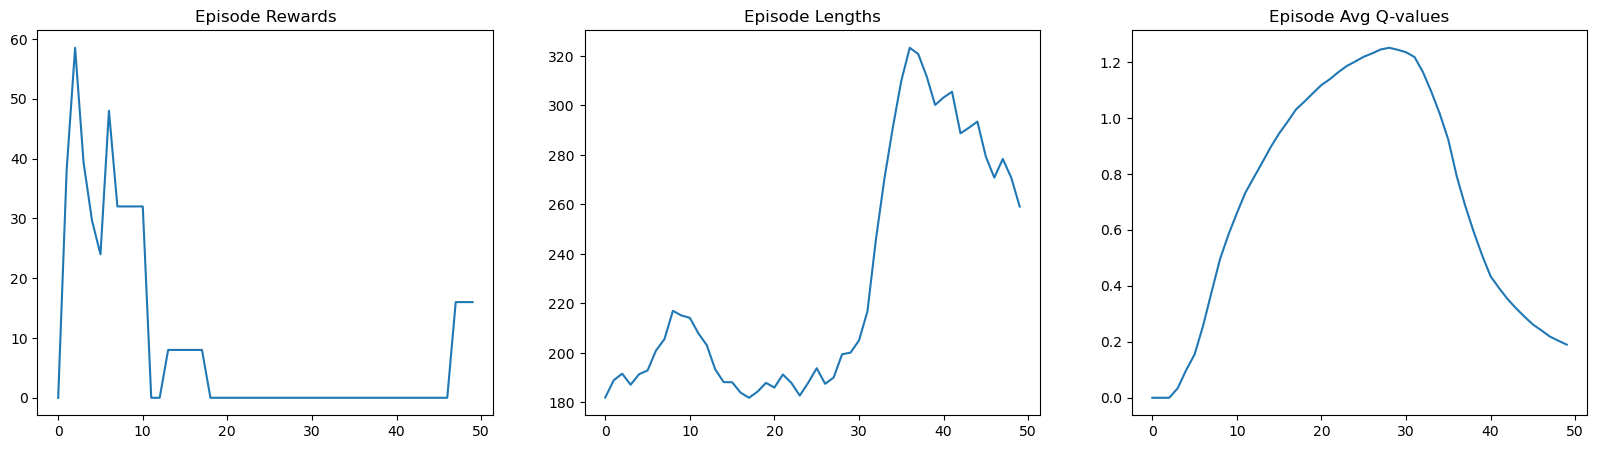

Average Reward over 0 episodes: nan
Evaluation reward: nan


/home/tianyhe/miniconda3/envs/mario-rl/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tianyhe/miniconda3/envs/mario-rl/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [2]:
from env import COMPLEX_MOVEMENT

# Define training parameters
ENV_ID = "ALE/MarioBros-v5"
EPISODES = 1000
SAVE_DIR = "./results/complex-1000-episodes-duelling-ddqn-priority"

# Train the agent
mario, logger = train(
    env_id=ENV_ID,
    episodes=EPISODES,
    save_dir=SAVE_DIR,
    action_set=COMPLEX_MOVEMENT,
    network_type="duelling",
    ddqn=True,
    priority=True,
    initial_noise=0.05,
    noise_decay=0.99
)

# Plot the training results
plot_training_results(logger)

# Evaluate the trained agent and capture gameplay frames
eval_reward, gameplay_frames = evaluate(ENV_ID, mario, episodes=0, action_set=SIMPLE_MOVEMENT, capture_frames=True)
print(f"Evaluation reward: {eval_reward}")

### Traditional DDQN with Prioritized Experience Replay (Simple Action Space)

In [ ]:
# Define training parameters
ENV_ID = "ALE/MarioBros-v5"
EPISODES = 1000
SAVE_DIR = "./results/simple-1000-episodes-dqn-ddqn-priority"

# Train the agent
mario, logger = train(
    env_id=ENV_ID,
    episodes=EPISODES,
    save_dir=SAVE_DIR,
    action_set=SIMPLE_MOVEMENT,
    network_type="DQN",
    ddqn=True,
    priority=True,
    initial_noise=0.05,
    noise_decay=0.99
)

# Plot the training results
plot_training_results(logger)

# Evaluate the trained agent and capture gameplay frames
eval_reward, gameplay_frames = evaluate(ENV_ID, mario, episodes=0, action_set=SIMPLE_MOVEMENT, capture_frames=True)
print(f"Evaluation reward: {eval_reward}")

### Dueling DQN with Prioritized Experience Replay (Simple Action Space)

In [ ]:
# Define training parameters
ENV_ID = "ALE/MarioBros-v5"
EPISODES = 1000
SAVE_DIR = "./results/simple-1000-episodes-duelling-dqn-priority"

# Train the agent
mario, logger = train(
    env_id=ENV_ID,
    episodes=EPISODES,
    save_dir=SAVE_DIR,
    action_set=SIMPLE_MOVEMENT,
    network_type="duelling",
    ddqn=False,
    priority=True,
    initial_noise=0.05,
    noise_decay=0.99
)

# Plot the training results
plot_training_results(logger)

# Evaluate the trained agent and capture gameplay frames
eval_reward, gameplay_frames = evaluate(ENV_ID, mario, episodes=0, action_set=SIMPLE_MOVEMENT, capture_frames=True)
print(f"Evaluation reward: {eval_reward}")

### Traditional DQN with Prioritized Experience Replay (Simple Action Space)

In [ ]:
# Define training parameters
ENV_ID = "ALE/MarioBros-v5"
EPISODES = 1000
SAVE_DIR = "./results/simple-1000-episodes-dqn-dqn-priority"

# Train the agent
mario, logger = train(
    env_id=ENV_ID,
    episodes=EPISODES,
    save_dir=SAVE_DIR,
    action_set=SIMPLE_MOVEMENT,
    network_type="dqn",
    ddqn=False,
    priority=True,
    initial_noise=0.05,
    noise_decay=0.99
)

# Plot the training results
plot_training_results(logger)

# Evaluate the trained agent and capture gameplay frames
eval_reward, gameplay_frames = evaluate(ENV_ID, mario, episodes=0, action_set=SIMPLE_MOVEMENT, capture_frames=True)
print(f"Evaluation reward: {eval_reward}")

## Let's Play!

### Function to load and visualize the trained agent's gameplay

In [1]:
"""
Visualize the trained agent's gameplay
"""

import sys
from pathlib import Path

src_path = Path.cwd().parent / "src"
if src_path not in sys.path:
    sys.path.append(str(src_path))


import torch
import numpy as np
from agent import Mario
from env import create_env, SIMPLE_MOVEMENT
import matplotlib.pyplot as plt
from IPython.display import clear_output
from gym.spaces import Discrete

def load_and_visualize_gameplay(model_path, env_id, episodes=1, tmax=500, action_set=None):
    # Load the saved model
    checkpoint = torch.load(model_path)
    state_dim = checkpoint['state_dim']
    action_dim = checkpoint['action_dim']
    
    # Create a new Mario instance and load the saved state
    mario = Mario(state_dim, action_dim, save_dir=".")
    mario.load(model_path)
    mario.net.eval()  # Set the network to evaluation mode
    
    # Determine the action space and create the environment
    if action_set is None:
        # Use the full action space if not specified
        env = create_env(env_id, full_action_space=True) 
    else:
        # Use the specified action set
        env = create_env(env_id, action_set=action_set)

    # Get full action meanings
    full_action_meanings = env.unwrapped.get_action_meanings()

    def process_state(state):
        if isinstance(state, tuple):
            state = state[0]  # Take the first element if it's a tuple
        if isinstance(state, dict):
            state = state['rgb']  # Assuming the image is under the 'rgb' key
        return np.array(state)

    # Create a figure with larger size for better visibility
    plt.figure(figsize=(15, 10))

    # Keep track of Q-values over time
    q_values_history = []

    for episode in range(episodes):
        state = env.reset()
        state = process_state(state)
        total_reward = 0
        
        for t in range(tmax):
            # Get Q-values for all actions the model was trained on
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(mario.device)
            q_values = mario.net(state_tensor).squeeze().detach().cpu().numpy()
            q_values_history.append(q_values)
            
            # Choose action with highest Q-value from the model's action space
            model_action = mario.act(state, eps=0.05)
            
            # Map the model's action to the current action space
            env_action = model_action % env.action_space.n
            action_meaning = full_action_meanings[env_action]
            
            # Take the action
            next_state, reward, done, truncated, info = env.step(env_action)
            next_state = process_state(next_state)
            total_reward += reward

            # Render the game state
            frame = env.render()
            
            # Display the frame, action, and Q-values
            plt.clf()
            plt.subplot(211)
            plt.imshow(frame)
            plt.title(f"Episode {episode + 1}, Step {t + 1}, Total Reward: {total_reward}", pad=20)
            plt.axis('off')
            
            plt.subplot(212)
            bars = plt.bar(range(action_dim), q_values, alpha=0.5)
            plt.plot(range(action_dim), q_values, 'ro-')  # Add line plot for better visibility
            plt.title(f"Q-values (Chosen action: {action_meaning} [{env_action}])", pad=50)
            plt.xlabel("Model's Action Space")
            plt.ylabel("Q-value")
            plt.ylim(min(0, np.min(q_values) - 0.1), np.max(q_values) + 0.1)  # Dynamic y-axis

            # Add text annotations for Q-values and action meanings
            for i, bar in enumerate(bars):
                height = bar.get_height()
                action_meaning = full_action_meanings[i % env.action_space.n]  # Get the action meaning
                plt.text(bar.get_x() + bar.get_width()/2., height,
                         f'{q_values[i]:.2f}\n{action_meaning}',
                         ha='center', va='bottom', rotation=45, fontsize=8)

            plt.tight_layout()
            clear_output(wait=True)
            plt.show()

            state = next_state
            
            if done or truncated:
                break

        print(f"Episode {episode + 1} finished with total reward: {total_reward}")

    env.close()

    # Plot Q-values over time after the episode
    plt.figure(figsize=(15, 8))
    plt.title("Q-values over time", pad=20)
    for i in range(action_dim):
        action_meaning = full_action_meanings[i % env.action_space.n]
        plt.plot([q[i] for q in q_values_history], label=f"{action_meaning}")
    plt.xlabel("Time step")
    plt.ylabel("Q-value")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

/home/tianyhe/miniconda3/envs/mario-rl/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### Load the Agent to Play

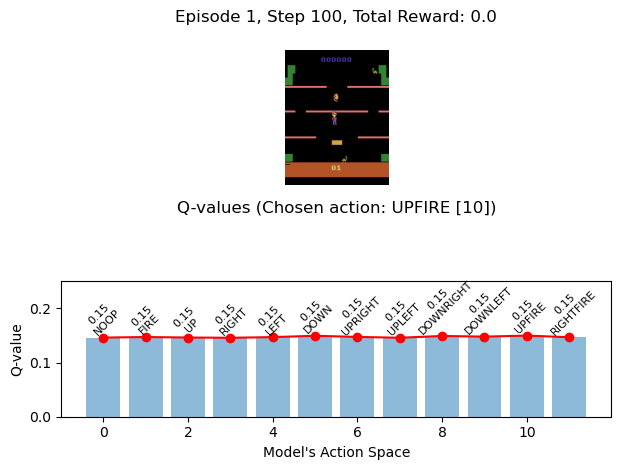

Episode 1 finished with total reward: 0.0


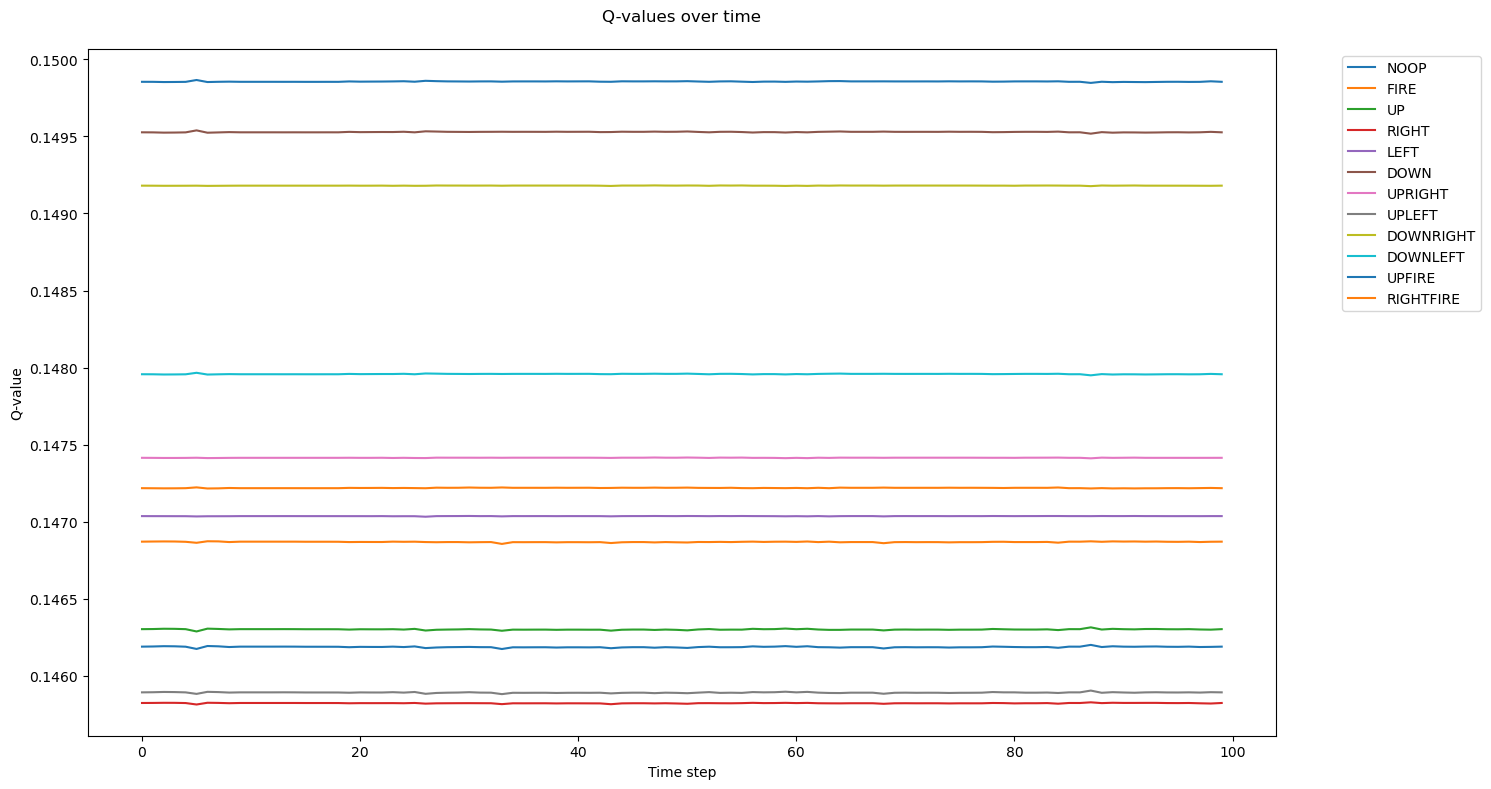

In [3]:
from env import SIMPLE_MOVEMENT, COMPLEX_MOVEMENT

# MODEL_PATH = "../model/dueling_ddqn_epo100_noise0.05_decay0.99_20240810_170626.checkpt" # Model path
MODEL_PATH = "../model/dueling_ddqn_epo1000_noise0.05_decay0.99_20240810_211810.checkpt"
ENV_ID = "ALE/MarioBros-v5" # Environment ID
EPISODES = 1 # Number of episodes to visualize
TMAX = 100 # Maximum number of steps per episode
ACTION_SET = None # Use the full action set

# Load the saved model and visualize gameplay
load_and_visualize_gameplay(MODEL_PATH, ENV_ID, episodes=EPISODES, tmax=TMAX, action_set=ACTION_SET)